In [1]:
import os
import cv2  # 이미지 로드를 위한 OpenCV 사용
import numpy as np

# 각 폴더에 대한 경로 설정
folder1_path = '/content/drive/MyDrive/skku-kkkc/Model/Data_Preprocessing/Real_MelSpectrogram_Img'  # 폴더 1 경로 (라벨 0)
folder2_path = '/content/drive/MyDrive/skku-kkkc/Model/Data_Preprocessing/Fake_MelSpectrogram_Img'  # 폴더 2 경로 (라벨 1)

# 이미지를 저장할 리스트 및 라벨 리스트 초기화
images = []
labels = []

# 폴더 1: 라벨 0 할당
for filename in os.listdir(folder1_path):
    img_path = os.path.join(folder1_path, filename)
    image = cv2.imread(img_path)  # 이미지 로드 (OpenCV 사용)
    # 이미지 처리 및 전처리 (이미지 크기 조정, 정규화 등)
    # 이미지 전처리 후
    images.append(image)  # 이미지 리스트에 추가
    labels.append(0)  # 라벨 0 추가

# 폴더 2: 라벨 1 할당
for filename in os.listdir(folder2_path):
    img_path = os.path.join(folder2_path, filename)
    image = cv2.imread(img_path)  # 이미지 로드 (OpenCV 사용)
    # 이미지 처리 및 전처리 (이미지 크기 조정, 정규화 등)
    # 이미지 전처리 후
    images.append(image)  # 이미지 리스트에 추가
    labels.append(1)  # 라벨 1 추가

# images와 labels 리스트를 numpy 배열로 변환
images = np.array(images)
labels = np.array(labels)

In [2]:
image_height = 400  # 이미지 높이
image_width = 1000   # 이미지 너비
num_channels = 3     # 이미지 채널 수 (RGB의 경우)

In [10]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

# 이미지와 라벨 데이터로 구성된 데이터셋 (images, labels)

# 데이터를 훈련, 검증, 테스트셋으로 분할
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# ResNet-50 모델 불러오기
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_height, image_width, num_channels))

# ResNet-50 모델을 기반으로 새로운 모델 정의
x = Flatten()(base_model.output)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # L2 Regularization 추가
x = Dropout(0.5)(x)  # Dropout 레이어 추가
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 기존 ResNet-50 모델의 레이어를 고정
for layer in base_model.layers:
    layer.trainable = False

# 모델 컴파일
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # 이진 분류를 위한 손실 함수
              metrics=['accuracy'])


In [11]:
# 모델 훈련
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# 모델 평가
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")

Epoch 1/10
5/5 [==============================] - 9s 1s/step - loss: 144.9841 - accuracy: 0.5191 - val_loss: 66.1675 - val_accuracy: 0.4848
Epoch 2/10
5/5 [==============================] - 4s 840ms/step - loss: 68.9265 - accuracy: 0.6107 - val_loss: 7.9959 - val_accuracy: 0.8485
Epoch 3/10
5/5 [==============================] - 4s 930ms/step - loss: 17.8861 - accuracy: 0.8168 - val_loss: 5.6817 - val_accuracy: 1.0000
Epoch 4/10
5/5 [==============================] - 4s 926ms/step - loss: 11.4812 - accuracy: 0.8473 - val_loss: 6.3264 - val_accuracy: 1.0000
Epoch 5/10
5/5 [==============================] - 4s 808ms/step - loss: 10.5203 - accuracy: 0.8779 - val_loss: 6.6528 - val_accuracy: 1.0000
Epoch 6/10
5/5 [==============================] - 4s 816ms/step - loss: 7.3784 - accuracy: 0.9542 - val_loss: 6.7163 - val_accuracy: 1.0000
Epoch 7/10
5/5 [==============================] - 5s 950ms/step - loss: 7.9663 - accuracy: 0.9542 - val_loss: 6.6069 - val_accuracy: 1.0000
Epoch 8/10
5/5 [

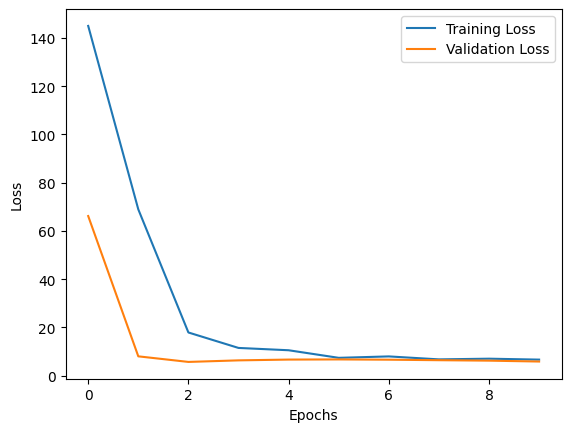

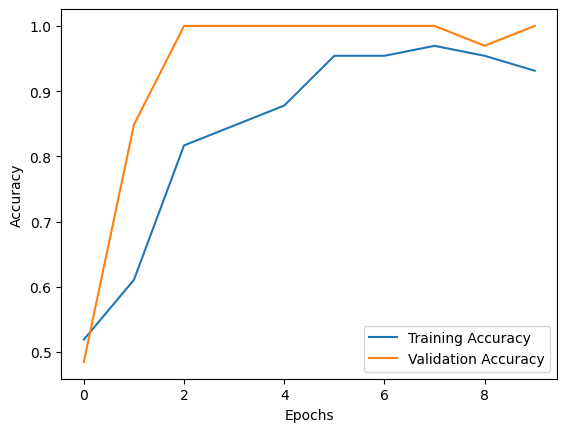

In [12]:
import matplotlib.pyplot as plt

# 훈련 및 검증 손실 시각화
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 훈련 및 검증 정확도 시각화
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


2/2 [==============================] - 1s 751ms/step


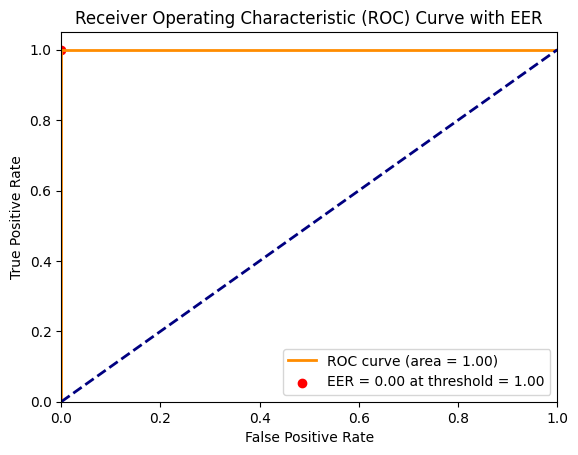

Area Under Curve (AUC): 1.0
Equal Error Rate (EER): 0.0


In [14]:
import matplotlib.pyplot as plt

# 모델로부터 예측값을 얻습니다.
y_pred = model.predict(X_test)

# ROC 곡선을 그립니다.
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_value = auc(fpr, tpr)

# EER 계산
eer = 1.0  # 초기값 설정
eer_threshold = 0.5  # EER을 계산할 임계값 설정
for i in range(len(fpr)):
    if fpr[i] + (1 - tpr[i]) < eer:
        eer = fpr[i] + (1 - tpr[i])
        eer_threshold = thresholds[i]

# ROC 곡선 그리기
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_value)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(eer, 1-eer, color='red', label=f'EER = {eer:.2f} at threshold = {eer_threshold:.2f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve with EER')
plt.legend(loc="lower right")
plt.show()

print(f"Area Under Curve (AUC): {auc_value}")
print(f"Equal Error Rate (EER): {eer}")
